# Data Analysis for Day 1 - IMC Prosperity 
### Team Achill Island

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import cm, pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
day_2 = pd.read_csv("A:\Historical Data\prices_round_1_day_-2.csv", sep = ";")
day_1 = pd.read_csv("A:\Historical Data\prices_round_1_day_-1.csv", sep = ";")
day_0 = pd.read_csv("A:\Historical Data\prices_round_1_day_0.csv", sep = ";")
day_2.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,BANANAS,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.000000
1,-2,0,PEARLS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.000000
2,-2,100,BANANAS,4997,20,NaN,NaN,NaN,NaN,4998,1,5004.0,20.0,NaN,NaN,4997.5,2.863281
3,-2,100,PEARLS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,-8.000000
4,-2,200,PEARLS,9996,1,9995.0,30.0,NaN,NaN,10004,1,10005.0,30.0,NaN,NaN,10000.0,-8.000000


In [3]:
def bid_ask_spread(df):
    """
    Generate the best-bid (1) to best-ask (1) spread across time for each instrument
    """
    pearls_df = df[df['product'] == 'PEARLS'].set_index('timestamp')
    banana_df = df[df['product'] == 'BANANAS'].set_index('timestamp')
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    for ax in axs:
        ax.ticklabel_format(style='plain', useOffset=False)
    
    # Plot Pearls
    axs[0].plot(pearls_df['bid_price_1'], label='Best Bid')
    axs[0].plot(pearls_df['ask_price_1'], label='Best Ask')
    axs[0].set_title('Pearls')
    
    # Plot Bananas
    axs[1].plot(banana_df['bid_price_1'], label='Best Bid')
    axs[1].plot(banana_df['ask_price_1'], label='Best Ask')
    axs[1].set_title('Bananas')
    axs[1].legend()
    
    return plt.show()

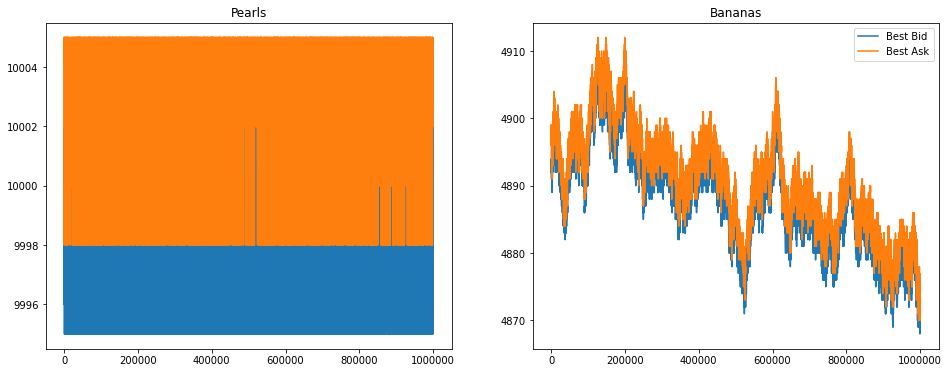

In [4]:
bid_ask_spread(day_0)

From this you can already see the trend in the data, and from that possibly the strategy which we may want to employ. 
Pearls are strictly mean-reverting while bananas are volatile and trending, therefore the implementation of a momentum strat is likely more appropriate. 

## Orderbook Imbalance
Balance between supply and demand of instrument based on the top of book. In real markets reflecting the sentiment of the market participants, here perhaps would indicate a bias in the price modelling of the instruments. 

In [5]:
def orderbook_imbalance(df):
    plt.figure(figsize=(20,5))
    df5 = df[['bid_price_1', 'ask_price_1', 'bid_volume_1', 'ask_volume_1', "mid_price"]]

    # Calculate spread as % of mid
    df5['spread'] = ((df5['ask_price_1'] - df5['bid_price_1']) / ((df5['ask_price_1'] + df5['bid_price_1']) / 2) * 10000).round(2)

    # Calculate log returns
    df5['log_returns'] = np.log(df5['mid_price'] / df5['mid_price'].shift(1))
    df5 = df5.dropna()

    # Calculate imbalance ratio
    df5['imbalance_ratio'] = ((df5['bid_volume_1'] - df5['ask_volume_1']) / (df5['bid_volume_1'] + df5['ask_volume_1'])).round(2)
    print("Imbalance Ratio:")
    print(df5['imbalance_ratio'].describe().round(2))

    df5.plot.scatter(x='imbalance_ratio', y='log_returns')
    slope, intercept = np.polyfit(df5['imbalance_ratio'], df5['log_returns'], 1)
    
    return plt.plot(df5['imbalance_ratio'], slope * df5['imbalance_ratio'] + intercept, color = 'red')

In [28]:
df = day_1
pearls_df = df[df['product'] == 'PEARLS'].set_index("timestamp")
banana_df = df[df['product'] == 'BANANAS'].set_index("timestamp")

#### PEARLS

Imbalance Ratio:
count    9999.00
mean        0.00
std         0.41
min        -1.00
25%         0.00
50%         0.00
75%         0.00
max         0.94
Name: imbalance_ratio, dtype: float64


<Figure size 1440x360 with 0 Axes>

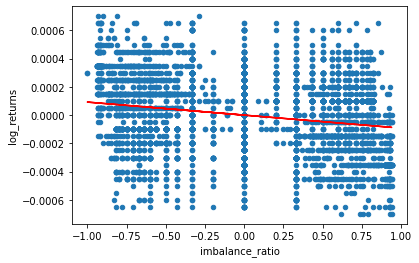

In [7]:
orderbook_imbalance(pearls_df)

Overall, this information suggests that the order book is relatively stable and that there is no significant bias towards buying or selling.

#### BANANAS

Imbalance Ratio:
count    9999.00
mean       -0.01
std         0.61
min        -0.94
25%        -0.60
50%         0.00
75%         0.56
max         0.94
Name: imbalance_ratio, dtype: float64


<Figure size 1440x360 with 0 Axes>

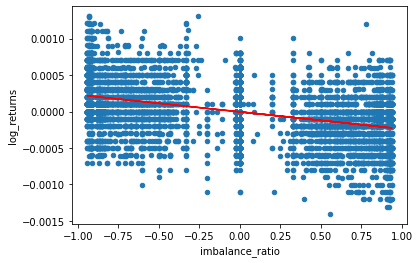

In [8]:
orderbook_imbalance(banana_df)

Again roughly balanced books across time, however, more violent swings (see std). Confirming that Bananas can see heavy swings in orderbook, with sometimes large imbalances in the data

## Pearls Basic Mean-Reversion

In [27]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
print(f"P-Value of ADF: {adfuller(pearls_df.mid_price)[1]}")

P-Value of ADF: 0.0


Stationary!!

In [29]:
pearls_df["ask_ER"] = abs(pearls_df.ask_price_1.mean() - pearls_df.ask_price_1)
pearls_df["bid_ER"] = abs(pearls_df.bid_price_1.mean() - pearls_df.bid_price_1)
pearls_df.tail()

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,ask_ER,bid_ER
timestamp,,,,,,,,,,,,,,,,,,
999500,-1,PEARLS,10000,5,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10002.0,-760.0,0.6056,3.4216
999600,-1,PEARLS,10000,4,9996.0,2.0,9995.0,28.0,10004,2,10005.0,28.0,NaN,NaN,10002.0,-760.0,0.6056,3.4216
999700,-1,PEARLS,9995,26,NaN,NaN,NaN,NaN,10005,26,NaN,NaN,NaN,NaN,10000.0,-760.0,1.6056,1.5784
999800,-1,PEARLS,9995,20,NaN,NaN,NaN,NaN,10002,10,10005.0,20.0,NaN,NaN,9998.5,-760.0,1.3944,1.5784
999900,-1,PEARLS,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,-760.0,0.6056,0.5784


#### Ask Analysis

In [35]:
pearls_df.ask_price_1.mean()

10003.3944

In [30]:
percentile_values_ask = pearls_df["ask_ER"].describe()
percentile_values_ask

count    10000.000000
mean         1.431608
std          1.313362
min          0.605600
25%          0.605600
50%          1.394400
75%          1.605600
max          5.394400
Name: ask_ER, dtype: float64

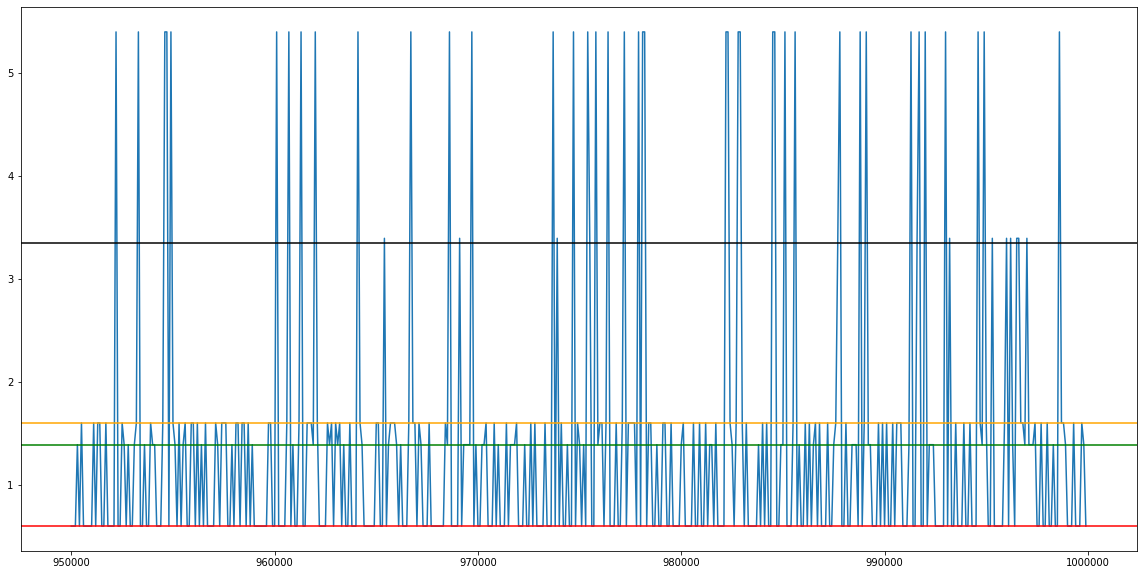

In [31]:
plt.figure(figsize = (20,10))
plt.ticklabel_format(style='plain', useOffset=False)
plt.plot(pearls_df.ask_ER[-500:])
plt.axhline(percentile_values_ask[4], c='red')
plt.axhline(percentile_values_ask[5], c='green')
plt.axhline(percentile_values_ask[6], c='orange')
plt.axhline(percentile_values_ask[2]*2.55, c='black')

Here we can see largely that only 25% of orders are greater than 1.632100 Expected Return. However, would how long does it take for that to die out? 

#### Bid Analysis

In [47]:
pearls_df.bid_price_1.mean()

9996.5784

In [46]:
percentile_values_bid = pearls_df["bid_ER"].describe()
percentile_values_bid

count    10000.000000
mean         1.396319
std          1.296501
min          0.578400
25%          0.578400
50%          1.421600
75%          1.578400
max          5.421600
Name: bid_ER, dtype: float64

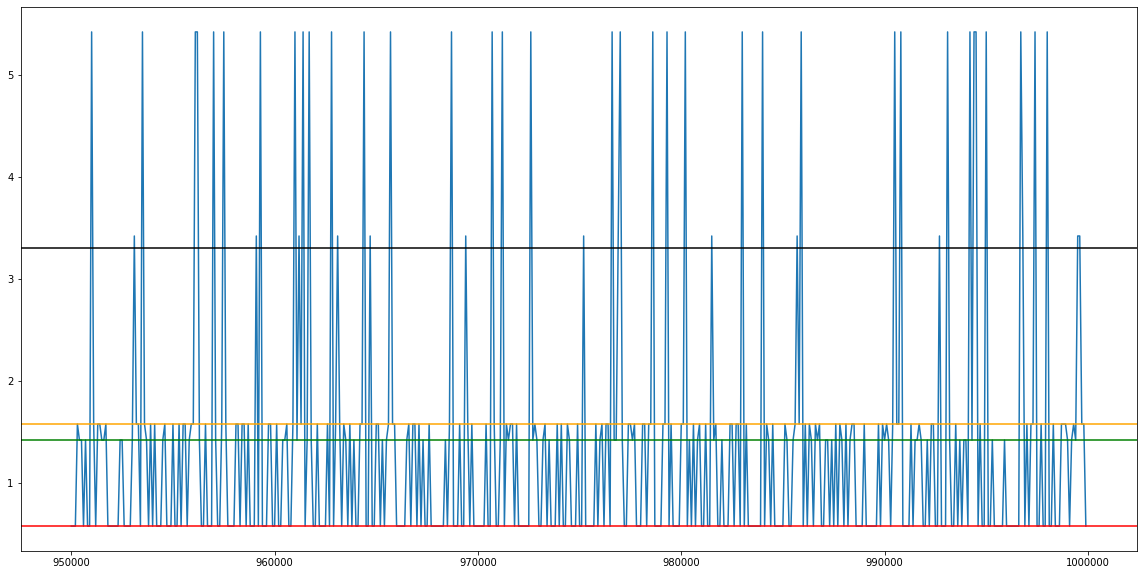

In [48]:
plt.figure(figsize = (20,10))
plt.ticklabel_format(style='plain', useOffset=False)
plt.plot(pearls_df.bid_ER[-500:])
plt.axhline(percentile_values_bid[4], c='red')
plt.axhline(percentile_values_bid[5], c='green')
plt.axhline(percentile_values_bid[6], c='orange')
plt.axhline(percentile_values_bid[2]*2.55, c='black')

Note we see largely the same changes in bids as we do asks

###### TO DO: Optimise Positioning Based on E(Return)